**Nama : Nur Muhammad Supyan <br>
NPM : 50420985 <br>
Kelas : 4IA12 <br>**

## **1. Import Pustaka**

In [ ]:
# Install pustaka Sastrawi
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Pustaka umum yang sering dipakai
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from google.colab import drive
drive.mount('/content/drive')

# Pustaka untuk NLP, transformasi ,dan membangun model
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **1. Pengumpulan Data**

In [ ]:
# Token Kredensial dari Youtube API
key = "TOKEN"

In [ ]:
# Fungsi Scrapping data Youtube
def get_comments(idVideo, maxScrapping=3500):
  youtube = build('youtube' , 'v3', developerKey=key)
  comments = []
  request = youtube.commentThreads().list(
    part='snippet',
    videoId=idVideo,
    maxResults=100)

  while len(comments) < maxScrapping:
    response = request.execute()

    for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      comments.append([
          comment['publishedAt'],
          comment['textDisplay']
      ])

      if len(comments) >= maxScrapping:
        return comments
      else:
        if "nextPageToken" in response:
          nextPageToken = response['nextPageToken']
          request = youtube.commentThreads().list(
              part='snippet',
              videoId=idVideo,
              maxResults=100,
              pageToken=nextPageToken
          )
        else:
          break

In [ ]:
# Memanggil Fungsi get_comments dengan argumen ID Video
comments = get_comments("RRgLZ66NCmE")

In [ ]:
# Simpan dalam bentuk Pandas dataframe
kolom = ['published', 'text']
df = pd.DataFrame(comments, columns=kolom)

In [ ]:
# Hitung jumlah data
df.count()

published    3500
text         3500
dtype: int64

In [ ]:
# Menampilkan beberapa data paling atas
df.head()

,published,text
0,2024-02-26T10:46:36Z,"TimeStamp Film:<br><br><a href=""https://www.yo..."
1,2024-07-04T14:54:58Z,58% iq otak udang tak bisa cerna isi video ini😂
2,2024-06-30T04:18:53Z,Untung masih ada videonya dan gak dihapus
3,2024-06-12T01:52:30Z,"saya datang terlambat kesini, andai dulu nonto..."
4,2024-06-11T05:37:26Z,Rewatch !!!


In [ ]:
path_comment = '/content/drive/MyDrive/skripsi/comment.csv'

In [ ]:
df.to_csv(path_comment, sep='|', index=False, encoding='utf-8')

## **2. Praproses Data**

In [ ]:
df = pd.read_csv(path_comment, sep='|', encoding='utf-8')

In [ ]:
df.head(10)

,published,text
0,2024-02-26T10:46:36Z,"TimeStamp Film:<br><br><a href=""https://www.yo..."
1,2024-07-04T14:54:58Z,58% iq otak udang tak bisa cerna isi video ini😂
2,2024-06-30T04:18:53Z,Untung masih ada videonya dan gak dihapus
3,2024-06-12T01:52:30Z,"saya datang terlambat kesini, andai dulu nonto..."
4,2024-06-11T05:37:26Z,Rewatch !!!
5,2024-06-10T12:49:02Z,MAU NGAKAK DIKASIH NIH VIDIO BUAT PILIH YANG C...
6,2024-06-09T07:04:52Z,Menang merayakan<br>Kalah menjelaskan
7,2024-06-07T04:04:47Z,Miris banget ngeliat negara yang kaya akan sum...
8,2024-06-03T13:12:00Z,"Ngaku ngga, ada penulis bang tere liye yg terl..."
9,2024-06-02T02:52:16Z,ga mempan dek


### **2.1 Case Folding**

In [ ]:
df["text"] = df["text"].str.lower()

In [ ]:
df.head(10)

,published,text
0,2024-02-26T10:46:36Z,"timestamp film:<br><br><a href=""https://www.yo..."
1,2024-07-04T14:54:58Z,58% iq otak udang tak bisa cerna isi video ini😂
2,2024-06-30T04:18:53Z,untung masih ada videonya dan gak dihapus
3,2024-06-12T01:52:30Z,"saya datang terlambat kesini, andai dulu nonto..."
4,2024-06-11T05:37:26Z,rewatch !!!
5,2024-06-10T12:49:02Z,mau ngakak dikasih nih vidio buat pilih yang c...
6,2024-06-09T07:04:52Z,menang merayakan<br>kalah menjelaskan
7,2024-06-07T04:04:47Z,miris banget ngeliat negara yang kaya akan sum...
8,2024-06-03T13:12:00Z,"ngaku ngga, ada penulis bang tere liye yg terl..."
9,2024-06-02T02:52:16Z,ga mempan dek


In [ ]:
path_case_folding = "/content/drive/MyDrive/skripsi/comment_folding.csv"

In [ ]:
df.to_csv(path_case_folding, sep="|", index=False, encoding='utf-8')

### **2.2 Cleaning**

In [ ]:
df.isnull().sum()

,0
published,0
text,55


In [ ]:
df = df.dropna(subset=["text"])

In [ ]:
df.isnull().sum()

,0
published,0
text,0


In [ ]:
def clean_comments(text):
  text = re.sub(r'<.*?>', ' ', text)
  text = re.sub(r'&[a-zA-Z]+;', '', text)
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)
  text = re.sub(r'\s\s+', ' ', text)
  text = text.split(" ")
  text = [kata for kata in text if len(kata) > 1]

  i = 0
  while i < len(text)-1:
    if text[i] == text[i+1]:
        text.pop(i+1)
        i += 1
    else:
        i += 1

  text = ' '.join(text)

  return text if text else np.nan

df["text"] = df["text"].apply(clean_comments)

In [ ]:
df.isnull().sum()

,0
published,0
text,91


In [ ]:
df = df.dropna(subset=["text"])

In [ ]:
df.isnull().sum()

,0
published,0
text,0


In [ ]:
df = df.drop_duplicates(subset=["text"])

In [ ]:
df = df[~df['text'].str.contains('timestamp', case=False, na=False)]

In [ ]:
df.count()

,0
published,3333
text,3333


In [ ]:
df.head(10)

,published,text
1,2024-07-04T14:54:58Z,iq otak udang tak bisa cerna isi video ini
2,2024-06-30T04:18:53Z,untung masih ada videonya dan gak dihapus
3,2024-06-12T01:52:30Z,saya datang terlambat kesini andai dulu nonton...
4,2024-06-11T05:37:26Z,rewatch
5,2024-06-10T12:49:02Z,mau ngakak dikasih nih vidio buat pilih yang c...
6,2024-06-09T07:04:52Z,menang merayakan kalah menjelaskan
7,2024-06-07T04:04:47Z,miris banget ngeliat negara yang kaya akan sum...
8,2024-06-03T13:12:00Z,ngaku ngga ada penulis bang tere liye yg terli...
9,2024-06-02T02:52:16Z,ga mempan dek
10,2024-05-22T14:21:54Z,dan sekarang sudah mulai terasa ukt naik pegas...


In [ ]:
path_cleaning = "/content/drive/MyDrive/skripsi/comment_clean.csv"

In [ ]:
df.to_csv(path_cleaning, sep="|", index=False, encoding='utf-8')

### **2.3 Normalisasi**

In [ ]:
kamus = {}
path_kamus = '/content/drive/MyDrive/skripsi/normalization.txt'
with open(path_kamus, "r") as file:
  for line in file:
    line = line.strip()
    if line:
      key, value = line.split('=', 1)
      kamus[key.strip()] = value.strip()

In [ ]:
print(kamus)

{'dg': 'dengan', 'yg': 'yang', 'mmg': 'memang', 'sbg': 'sebagai', 'seblm': 'sebelum', 'sblum': 'sebelum', 'sblm': 'sebelum', 'kpd': 'kepada', 'dlm': 'dalam', 'hrs': 'harus', 'pak': 'bapak', 'smua': 'semua', 'ad': 'ada', 'untk': 'untuk', 'sy': 'saya', 'smngat': 'semangat', 'mrk': 'mereka', 'teruss': 'terus', 'tdk': 'tidak', 'pdhl': 'padahal', 'negri': 'negeri', 'gak': 'tidak', 'dr': 'dari', 'robb': 'tuhan', 'sdh': 'sudah', 'dsn': 'dan', 'all': 'semua', 'utk': 'untuk', 'smg': 'semoga', 'klian': 'kalian', 'slalu': 'selalu', 'zholim': 'zalim', 'karna': 'karena', 'org': 'orang', 'tpi': 'tapi', 'gua': 'saya', 'gw': 'saya', 'nggak': 'tidak', 'ngga': 'tidak', 'tgl': 'tanggal', 'crew': 'kru', 'bpk': 'bapak', 'flem': 'film', 'tak': 'tidak', 'trima': 'terima', 'mu': 'kamu', 'tau': 'tahu', 'gaa': 'tidak', 'ga': 'tidak', 'engga': 'tidak', 'diliat': 'lihat', 'gk': 'tidak', 'guna': 'berguna', 'hapis': 'hapus', 'dri': 'dari', 'flm': 'film', 'pepek': 'vagina', 'dgn': 'dengan', 'aah': 'ah', 'lagak': 'be

In [ ]:
def normalisasi(text, kamus):
    text = text.split()
    norm_kata = [kamus.get(kata, kata) for kata in text]
    norm_text = ' '.join(norm_kata)
    return norm_text

df["text"] = df["text"].apply(lambda x: normalisasi(x, kamus))

In [ ]:
df.head(10)

,published,text
1,2024-07-04T14:54:58Z,iq otak udang tidak bisa cerna isi video ini
2,2024-06-30T04:18:53Z,untung masih ada videonya dan tidak dihapus
3,2024-06-12T01:52:30Z,saya datang terlambat ke sini andai dulu nonto...
4,2024-06-11T05:37:26Z,rewatch
5,2024-06-10T12:49:02Z,mau ngakak dikasih nih video buat pilih yang p...
6,2024-06-09T07:04:52Z,menang merayakan kalah menjelaskan
7,2024-06-07T04:04:47Z,miris banget ngeliat negara yang seperti akan ...
8,2024-06-03T13:12:00Z,ngaku tidak ada penulis bapak tere liye yang t...
9,2024-06-02T02:52:16Z,tidak mempan dek
10,2024-05-22T14:21:54Z,dan sekarang sudah mulai terasa ukt naik pegas...


In [ ]:
path_norm = "/content/drive/MyDrive/skripsi/comment_norm.csv"

In [ ]:
df.to_csv(path_norm, sep="|", index=False, encoding='utf-8')

### **2.4 Tokenisasi**

In [ ]:
# Membaca Data yang telah di normalisasi lewat CSV
df = pd.read_csv(path_norm, sep="|", encoding='utf-8')
df.head()

,published,text
0,2024-07-04T14:54:58Z,iq otak udang tidak bisa cerna isi video ini
1,2024-06-30T04:18:53Z,untung masih ada videonya dan tidak dihapus
2,2024-06-12T01:52:30Z,saya datang terlambat ke sini andai dulu nonto...
3,2024-06-11T05:37:26Z,rewatch
4,2024-06-10T12:49:02Z,mau ngakak dikasih nih video buat pilih yang p...


In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def tokenize(text):
  tokenize_comments = word_tokenize(text)

  return tokenize_comments

df["text"] = df["text"].apply(tokenize)

In [ ]:
df.head(10)

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, bisa, cerna, isi, vid..."
1,2024-06-30T04:18:53Z,"[untung, masih, ada, videonya, dan, tidak, dih..."
2,2024-06-12T01:52:30Z,"[saya, datang, terlambat, ke, sini, andai, dul..."
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[mau, ngakak, dikasih, nih, video, buat, pilih..."
5,2024-06-09T07:04:52Z,"[menang, merayakan, kalah, menjelaskan]"
6,2024-06-07T04:04:47Z,"[miris, banget, ngeliat, negara, yang, seperti..."
7,2024-06-03T13:12:00Z,"[ngaku, tidak, ada, penulis, bapak, tere, liye..."
8,2024-06-02T02:52:16Z,"[tidak, mempan, dek]"
9,2024-05-22T14:21:54Z,"[dan, sekarang, sudah, mulai, terasa, ukt, nai..."


In [ ]:
path_token = "/content/drive/MyDrive/skripsi/comment_token.csv"

In [ ]:
df.to_csv(path_token, sep="|", index=False, encoding='utf-8')

### **2.5 Stopword Removal**

In [ ]:
# hanya dijalankan ketika data baru keluar dari CSV
df = pd.read_csv(path_token, sep="|", encoding='utf-8')

df['text'] = df['text'].apply(clean_comments)
df['text'] = df['text'].apply(tokenize)
df.head()

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, bisa, cerna, isi, vid..."
1,2024-06-30T04:18:53Z,"[untung, masih, ada, videonya, dan, tidak, dih..."
2,2024-06-12T01:52:30Z,"[saya, datang, terlambat, ke, sini, andai, dul..."
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[mau, ngakak, dikasih, nih, video, buat, pilih..."


In [ ]:
stop_words = list(stopwords.words("indonesian"))

In [ ]:
file_path = '/content/drive/MyDrive/skripsi/stopword.txt'
with open(file_path, 'r') as file:
    content = file.read()

stopwords_tambahan = content.split()

print(stopwords_tambahan)

['ahh', 'aja', 'anu', 'woi', 'woy', 'gih', 'dll', 'deh', 'ah', 'ap', 'lg', 'eh', 'ehh', 'si', 'lah', 'loh', 'leh', 'lol', 'tuh', 'kan', 'kah', 'halah', 'heleh', 'oh', 'sry', 'ye', 'yee', 'yak', 'yah', 'ni', 'nih', 'nya', 'ny', 'aja', 'sih', 'dkk', 'mah', 'gas', 'ea', 'hut', 'bos', 'boy', 'per', 'pun', 'jir', 'dah', 'si', 'dek', 'jka', 'tuch', 'klaw', 'sypa', 'spya', 'emng', 'ciee', 'cieee', 'bro', 'brow', 'trs', 'bua', 'ha', 'cuiy', 'cuk', 'yey', 'kah', 'dsb', 'tsb', 'yaa', 'dekkkk', 'uhuy', 'hiya', 'leng', 'kek', 'toh', 'blabla', 'blas', 'tas', 'for', 'up', 'in', 'heh', 'pret', 'ayuk', 'hmm', 'nt', 'hadeh', 'to', 'om', 'mas', 'abang', 'mba', 'embak', 'tante', 'hayo', 'yra', 'gbu', 'swt', 'aamiin', 'aaamiiin', 'dh', 'yh', 'ehkkkk', 'noh', 'di', 'wooo', 'oooh', 'ih', 'iih', 'ja', 'mk', 'er', 'an', 'preeeettt', 'th', 'kh', 'gas', 'gassss', 'okey', 'duhhhh', 'dst', 'up', 'sm', 'kn', 'ter', 'koo', 'yaaa', 'yeee', 'aaaaa', 'meng', 'dtv', 'ooo', 'no', 'coo', 'heeeyyy', 'waw', 'aje', 'yh', 'b

In [ ]:
stop_words.extend(stopwords_tambahan)
remove_stopwords = [
    "jangan", "tidak", "belum",
    "bukan", "tanpa", "biasa"
]
for kata in remove_stopwords:
  stop_words.remove(kata)

In [ ]:
print(stop_words)

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berken

In [ ]:
def clean_stopwords(text):
  clean_text = []
  for kata in text:
    if kata not in stop_words:
      clean_text.append(kata)
    else:
      continue

  return clean_text if clean_text else np.nan

df['text'] = df['text'].apply(clean_stopwords)

In [ ]:
df.head(10)

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]"
1,2024-06-30T04:18:53Z,"[untung, videonya, tidak, dihapus]"
2,2024-06-12T01:52:30Z,"[terlambat, andai, nonton, video]"
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[ngakak, dikasih, video, pilih, pintar, pilih,..."
5,2024-06-09T07:04:52Z,"[menang, merayakan, kalah]"
6,2024-06-07T04:04:47Z,"[miris, banget, ngeliat, negara, sumber, daya,..."
7,2024-06-03T13:12:00Z,"[ngaku, tidak, penulis, tere, liye, terlibat, ..."
8,2024-06-02T02:52:16Z,"[tidak, mempan]"
9,2024-05-22T14:21:54Z,"[ukt, pegasus, alat, penyadap, masuk, lihat, c..."


In [ ]:
df.isnull().sum()

,0
published,0
text,25


In [ ]:
df = df.dropna(subset=["text"])

In [ ]:
df.isnull().sum()

,0
published,0
text,0


In [ ]:
df.count()

,0
published,3308
text,3308


In [ ]:
path_stopwords = "/content/drive/MyDrive/skripsi/comment_stopword.csv"

In [ ]:
df.to_csv(path_stopwords, sep="|", index=False, encoding='utf-8')

### **2.6 Stemming**

In [ ]:
# hanya dijalankan ketika data baru keluar dari CSV
df = pd.read_csv(path_stopwords, sep="|", encoding='utf-8')

df['text'] = df['text'].apply(clean_comments)
df['text'] = df['text'].apply(tokenize)
df.head()

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]"
1,2024-06-30T04:18:53Z,"[untung, videonya, tidak, dihapus]"
2,2024-06-12T01:52:30Z,"[terlambat, andai, nonton, video]"
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[ngakak, dikasih, video, pilih, pintar, pilih,..."


In [ ]:
def stem_comment(text):
  hasil = []
  Factory = StemmerFactory()
  Stemmer = Factory.create_stemmer()
  for kata in text:
    stem = Stemmer.stem(kata)
    hasil.append(stem)

  return hasil

df["text"] = df["text"].apply(stem_comment)

In [ ]:
df.head(10)

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]"
1,2024-06-30T04:18:53Z,"[untung, video, tidak, hapus]"
2,2024-06-12T01:52:30Z,"[lambat, andai, nonton, video]"
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[ngakak, kasih, video, pilih, pintar, pilih, s..."
5,2024-06-09T07:04:52Z,"[menang, raya, kalah]"
6,2024-06-07T04:04:47Z,"[miris, banget, ngeliat, negara, sumber, daya,..."
7,2024-06-03T13:12:00Z,"[ngaku, tidak, tulis, tere, liye, libat, produ..."
8,2024-06-02T02:52:16Z,"[tidak, mempan]"
9,2024-05-22T14:21:54Z,"[ukt, pegasus, alat, sadap, masuk, lihat, cawe..."


In [ ]:
df.count()

,0
published,3308
text,3308


In [ ]:
path_stem = "/content/drive/MyDrive/skripsi/comment_stem.csv"

In [ ]:
df.to_csv(path_stem, sep="|", index=False, encoding='utf-8')

### **2.7 Pelabelan**

In [ ]:
# hanya dijalankan ketika data baru keluar dari CSV
df = pd.read_csv(path_stem, sep="|", encoding='utf-8')

df['text'] = df['text'].apply(clean_comments)
df['text'] = df['text'].apply(tokenize)
df.head()

,published,text
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]"
1,2024-06-30T04:18:53Z,"[untung, video, tidak, hapus]"
2,2024-06-12T01:52:30Z,"[lambat, andai, nonton, video]"
3,2024-06-11T05:37:26Z,[rewatch]
4,2024-06-10T12:49:02Z,"[ngakak, kasih, video, pilih, pintar, pilih, s..."


In [ ]:
# Path dari kamus lexicon di drive
path_word = "/content/drive/MyDrive/skripsi/lexicon.txt"
path_idiom = "/content/drive/MyDrive/skripsi/idioms.txt"
path_negation = "/content/drive/MyDrive/skripsi/negasi.txt"

In [ ]:
# Fungsi untuk memasukkan daftar kamus lexicon ke dictionary
def load_lexicon(path):
    lexicon_dict = {}
    with open(path, 'r') as file:
        for line in file:
            key, value = line.strip().split(":")
            lexicon_dict[key] = int(value)
    return lexicon_dict

In [ ]:
# Fungsi untuk memasukkan daftar negasi ke list
def load_negation(path):
    with open(path, 'r') as file:
        negation = [line.strip() for line in file]
    return negation

In [ ]:
# Memanggil Fungsi load_lexicon dan load_negasi
lexicon = load_lexicon(path_word)
idioms = load_lexicon(path_idiom)
negation = load_negation(path_negation)

In [ ]:
# Memeriksa apakah kata tersebut termasuk negasi
def is_negation(word):
  return word in negation

In [ ]:
def sentiment_score(text):
    score = 0
    negation_val = False
    i = 0

    while i < len(text):
        if i < len(text) - 1:
            word_idiom = text[i] + " " + text[i + 1]
            if word_idiom in idioms:
                score += idioms[word_idiom]
                i += 2
                continue

        word = text[i]

        if word in lexicon:
            if negation_val:
                score -= lexicon[word]
                negation_val = False
            else:
                score += lexicon[word]
        elif is_negation(word):
            negation_val = True
        else:
            negation_val = False

        i += 1

    return score


df["score"] = df["text"].apply(sentiment_score)

In [ ]:
df.head(10)

,published,text,score
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]",-4
1,2024-06-30T04:18:53Z,"[untung, video, tidak, hapus]",0
2,2024-06-12T01:52:30Z,"[lambat, andai, nonton, video]",-3
3,2024-06-11T05:37:26Z,[rewatch],0
4,2024-06-10T12:49:02Z,"[ngakak, kasih, video, pilih, pintar, pilih, s...",5
5,2024-06-09T07:04:52Z,"[menang, raya, kalah]",0
6,2024-06-07T04:04:47Z,"[miris, banget, ngeliat, negara, sumber, daya,...",-6
7,2024-06-03T13:12:00Z,"[ngaku, tidak, tulis, tere, liye, libat, produ...",-10
8,2024-06-02T02:52:16Z,"[tidak, mempan]",0
9,2024-05-22T14:21:54Z,"[ukt, pegasus, alat, sadap, masuk, lihat, cawe...",4


In [ ]:
def sentiment_label(score):
  if score > 0:
    return 0
  elif score < 0:
    return 2
  else:
    return 1

df["sentiment"] = df["score"].apply(sentiment_label)

In [ ]:
df.head(10)

,published,text,score,sentiment
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]",-4,2
1,2024-06-30T04:18:53Z,"[untung, video, tidak, hapus]",0,1
2,2024-06-12T01:52:30Z,"[lambat, andai, nonton, video]",-3,2
3,2024-06-11T05:37:26Z,[rewatch],0,1
4,2024-06-10T12:49:02Z,"[ngakak, kasih, video, pilih, pintar, pilih, s...",5,0
5,2024-06-09T07:04:52Z,"[menang, raya, kalah]",0,1
6,2024-06-07T04:04:47Z,"[miris, banget, ngeliat, negara, sumber, daya,...",-6,2
7,2024-06-03T13:12:00Z,"[ngaku, tidak, tulis, tere, liye, libat, produ...",-10,2
8,2024-06-02T02:52:16Z,"[tidak, mempan]",0,1
9,2024-05-22T14:21:54Z,"[ukt, pegasus, alat, sadap, masuk, lihat, cawe...",4,0


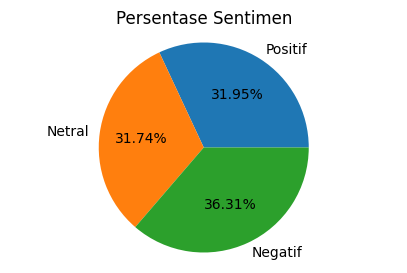

In [ ]:
# Diagram Lingkaran
# Buat dictionary keterangan label
label_map = {
    0: 'Positif',
    1: 'Netral',
    2: 'Negatif'
}

# Ambil label dan jumlahnya
label, count = np.unique(
    df['sentiment'],
    return_counts=True
)

label_desc = [label_map[i] for i in label]

plt.figure(figsize=(5, 3))
plt.pie(
    count,
    labels=label_desc,
    autopct='%1.2f%%'
)
plt.axis('equal')
plt.title('Persentase Sentimen')

plt.show()

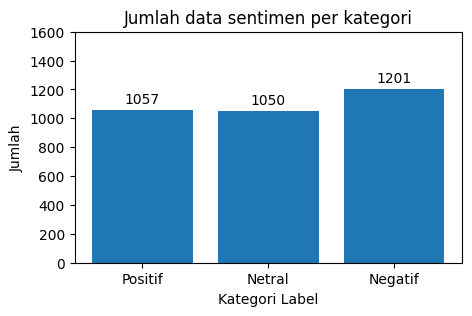

In [ ]:
# Diagram Batang
plt.figure(figsize = (5, 3))

# creating the bar plot
bars = plt.bar(
    label_desc,
    count,
)

for bar in bars:
  height = bar.get_height()
  pos_x = bar.get_x()
  width = bar.get_width()
  pos = pos_x + width / 2
  plt.text(
      pos_x + width / 2,
      height + 50,
      height,
      ha='center'
  )

plt.xlabel("Kategori Label")
plt.ylim(0, 1600)
plt.ylabel("Jumlah")
plt.title("Jumlah data sentimen per kategori")
plt.show()

In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x))

positif_text = ' '.join(df[df['sentiment'] == 0]['text'])
negatif_text = ' '.join(df[df['sentiment'] == 2]['text'])
netral_text = ' '.join(df[df['sentiment'] == 1]['text'])

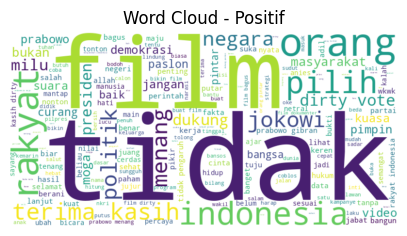

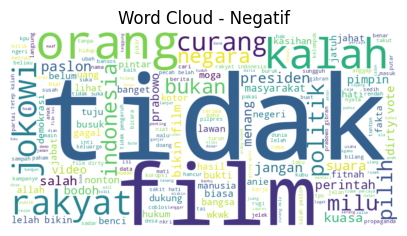

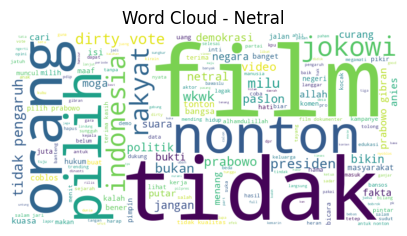

In [ ]:
# Buat word cloud untuk setiap kategori
def show_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(text)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Tampilkan word cloud untuk setiap kategori
show_wordcloud(positif_text, 'Word Cloud - Positif')
show_wordcloud(negatif_text, 'Word Cloud - Negatif')
show_wordcloud(netral_text, 'Word Cloud - Netral')

In [ ]:
path_label = "/content/drive/MyDrive/skripsi/comment_label.csv"

In [ ]:
df.to_csv(path_label, sep="|", index=False, encoding='utf-8')

## **3. Transformasi Data**

In [ ]:
#Jalankan setelah data baru keluar dari CSV
df = pd.read_csv(path_label, sep="|", encoding='utf-8')

df['text'] = df['text'].apply(clean_comments)
df['text'] = df['text'].apply(tokenize)

df.head()

,published,text,score,sentiment
0,2024-07-04T14:54:58Z,"[iq, otak, udang, tidak, cerna, isi, video]",-4,2
1,2024-06-30T04:18:53Z,"[untung, video, tidak, hapus]",0,1
2,2024-06-12T01:52:30Z,"[lambat, andai, nonton, video]",-3,2
3,2024-06-11T05:37:26Z,[rewatch],0,1
4,2024-06-10T12:49:02Z,"[ngakak, kasih, video, pilih, pintar, pilih, s...",5,0


In [ ]:
df['text'] = df["text"].apply(lambda x: " ".join(x))

In [ ]:
texts = df['text']
label = df['sentiment']

In [ ]:
# # Bagi data menjadi data latih dan data uji
# # Proporsi 90:10
# x_train, x_test, y_train, y_test = train_test_split(
#     df['text'],
#     df['sentiment'],
#     test_size=0.1,
#     random_state=42
# )

In [ ]:
# # Proporsi 80:20
# x_train, x_test, y_train, y_test = train_test_split(
#     texts,
#     label,
#     test_size=0.2,
#     random_state=42
# )

In [ ]:
# Proporsi 70:30
x_train, x_test, y_train, y_test = train_test_split(
    texts,
    label,
    test_size=0.3,
    random_state=42
)

In [ ]:
x_train.count()

2315

In [ ]:
x_test.count()

993

In [ ]:
vectorizer = TfidfVectorizer()
x_train_tf = vectorizer.fit_transform(x_train)
x_test_tf = vectorizer.transform(x_test)

In [ ]:
print(x_train_tf)

  (0, 1272)	0.3644594111553728
  (0, 3373)	0.4097151924385361
  (0, 1606)	0.5724172056251264
  (0, 369)	0.35487086078090174
  (0, 2725)	0.2680515106767811
  (0, 3612)	0.3246742321750287
  (0, 125)	0.2616162154067037
  (1, 4460)	1.0
  (2, 1910)	0.8102080589867511
  (2, 2392)	0.5861423898276946
  (3, 1652)	0.4590360424279225
  (3, 1397)	0.26712843643521955
  (3, 1643)	0.2815917965463263
  (3, 1029)	0.2360835584570948
  (3, 3035)	0.6888743231417969
  (3, 1155)	0.12453536998050385
  (3, 3515)	0.30469990528975177
  (4, 4131)	0.23079857363987707
  (4, 195)	0.7416439461142922
  (4, 1358)	0.5901096355483387
  (4, 1155)	0.2201519784849228
  (5, 4519)	0.5118135330379593
  (5, 1618)	0.4019978456208534
  (5, 4065)	0.5267136218683174
  (5, 445)	0.39851969390595493
  :	:
  (2312, 1155)	0.11348987610738621
  (2313, 1974)	0.45186948221463746
  (2313, 3209)	0.45186948221463746
  (2313, 365)	0.42912214177134156
  (2313, 4183)	0.3562299698404633
  (2313, 3275)	0.34685792756040973
  (2313, 2219)	0.2557089

In [ ]:
print(x_test_tf)

  (0, 4131)	0.14968321620683261
  (0, 3708)	0.4664090743075576
  (0, 2696)	0.4809893292838516
  (0, 1155)	0.14277842221563483
  (0, 31)	0.4809893292838516
  (0, 26)	0.5262797379429508
  (1, 3579)	0.5409552967203134
  (1, 3035)	0.3997905075402695
  (1, 2239)	0.5758230365132554
  (1, 1155)	0.2168235500961149
  (1, 1029)	0.41103563808422117
  (2, 2694)	0.8919838317234802
  (2, 1760)	0.4520673002373629
  (3, 3612)	1.0
  (4, 3974)	0.6521713626634327
  (4, 3244)	0.4481608244336603
  (4, 1270)	0.5486596842791653
  (4, 1155)	0.2698090806688124
  (5, 3150)	0.35809665222839576
  (5, 3061)	0.4357372552100911
  (5, 2852)	0.29133578702350515
  (5, 2725)	0.33693238656145863
  (5, 1874)	0.45183647000252364
  (5, 1402)	0.3225657813288491
  (5, 493)	0.41868243247305437
  :	:
  (990, 2513)	0.3094529305441384
  (990, 1761)	0.3485032909011634
  (990, 1163)	0.4126920777655889
  (991, 2656)	0.58938675559754
  (991, 1025)	0.5321546636642877
  (991, 394)	0.6078113739200302
  (992, 4238)	0.22388137459820373
  

## **4. Klasifikasi Algoritma Machine Learning**

### **4.1 Klasifikasi Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Membuat objek klasifikasi
poly = SVC(
    kernel="poly",
    decision_function_shape="ovr",
    max_iter=5000
)

rbf = SVC(
    kernel="rbf",
    decision_function_shape="ovr",
    max_iter=5000
)

sigmoid = SVC(
    kernel="sigmoid",
    decision_function_shape="ovr",
    max_iter=5000
)

In [ ]:
# Melatih ketiga kernel dengan data latih dan
poly.fit(x_train_tf, y_train)
rbf.fit(x_train_tf, y_train)
sigmoid.fit(x_train_tf, y_train)

SVC(kernel='sigmoid', max_iter=5000)

In [ ]:
y_predict_poly = poly.predict(x_test_tf)
y_predict_rbf = rbf.predict(x_test_tf)
y_predict_sigmoid = sigmoid.predict(x_test_tf)

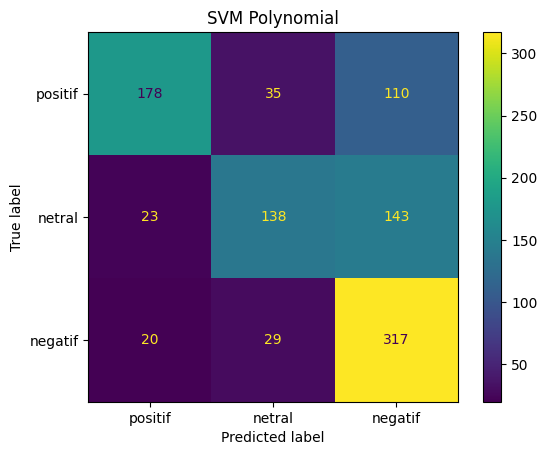

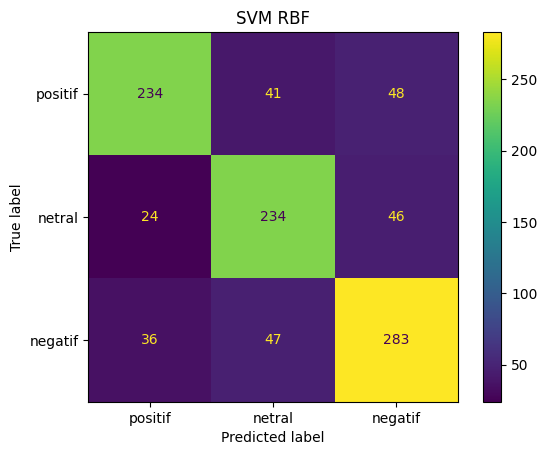

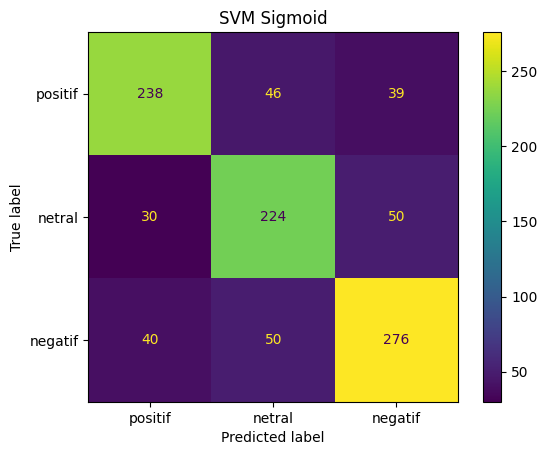

In [ ]:
label_cm = ["positif", "netral", "negatif"]

# Confusion matrix untuk model Polynomial
disp_poly = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_predict_poly,
    display_labels=label_cm
)
disp_poly.ax_.set_title("SVM Polynomial")
plt.show()

# Confusion matrix untuk model RBF
disp_rbf = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_predict_rbf,
    display_labels=label_cm
)
disp_rbf.ax_.set_title("SVM RBF")
plt.show()

# Confusion matrix untuk model Sigmoid
disp_sigmoid = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_predict_sigmoid,
    display_labels=label_cm
)
disp_sigmoid.ax_.set_title("SVM Sigmoid")
plt.show()

### **4.2 Klasifikasi Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
logit = LogisticRegression(
    multi_class="multinomial",
    max_iter=3500
)
logit.fit(x_train_tf, y_train)

LogisticRegression(max_iter=3500, multi_class='multinomial')

In [ ]:
y_predict_logit = logit.predict(x_test_tf)

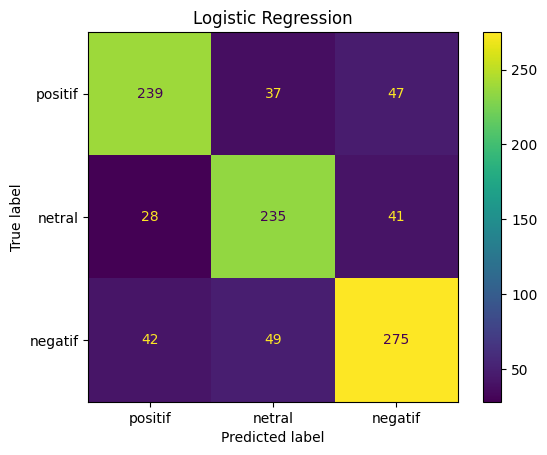

In [ ]:
# Confusion matrix untuk model Logistic Regression
label_cm = ["positif", "netral", "negatif"]

disp_lr = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_predict_logit,
    display_labels=label_cm
)
disp_lr.ax_.set_title("Logistic Regression")
plt.show()

## **5. Evaluasi**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report_label = ["positif", "netral", "negatif"]

In [ ]:
poly_report = classification_report(
    y_test,
    y_predict_poly,
    target_names=report_label
)
print(poly_report)

              precision    recall  f1-score   support

     positif       0.81      0.55      0.65       323
      netral       0.68      0.45      0.55       304
     negatif       0.56      0.87      0.68       366

    accuracy                           0.64       993
   macro avg       0.68      0.62      0.63       993
weighted avg       0.68      0.64      0.63       993



In [ ]:
rbf_report = classification_report(
    y_test,
    y_predict_rbf,
    target_names=report_label
)
print(rbf_report)

              precision    recall  f1-score   support

     positif       0.80      0.72      0.76       323
      netral       0.73      0.77      0.75       304
     negatif       0.75      0.77      0.76       366

    accuracy                           0.76       993
   macro avg       0.76      0.76      0.76       993
weighted avg       0.76      0.76      0.76       993



In [ ]:
sigmoid_report = classification_report(
    y_test,
    y_predict_sigmoid,
    target_names=report_label
)
print(sigmoid_report)

              precision    recall  f1-score   support

     positif       0.77      0.74      0.75       323
      netral       0.70      0.74      0.72       304
     negatif       0.76      0.75      0.76       366

    accuracy                           0.74       993
   macro avg       0.74      0.74      0.74       993
weighted avg       0.74      0.74      0.74       993



In [ ]:
logit_report = classification_report(
    y_test,
    y_predict_logit,
    target_names=report_label
)
print(logit_report)

              precision    recall  f1-score   support

     positif       0.77      0.74      0.76       323
      netral       0.73      0.77      0.75       304
     negatif       0.76      0.75      0.75       366

    accuracy                           0.75       993
   macro avg       0.75      0.75      0.75       993
weighted avg       0.75      0.75      0.75       993

